In [98]:
import numpy as np
import sys

sys.path.append('../') 

from reclab.recommenders import LibFM
from reclab import data_utils

In [114]:
num_users = 943
num_items = 1682

regs = [0.0001, 0.001, 0.01, 0.1, 1]

default_params = dict(num_two_way_factors=8, learning_rate=0.1,
              bias_reg=0., one_way_reg=0., two_way_reg=0., 
              num_iter=100)

params_list = [(reg, dict(bias_reg=reg, one_way_reg=reg, two_way_reg=reg)) for reg in regs]

## default params + new params -- then pass in the new param for gridding and easy plotting

users, items, ratings = data_utils.read_movielens100k()

In [115]:
indices = np.random.permutation(len(ratings))

In [116]:
# ratings.keys()[5]

In [117]:
n_fold = 5
size_fold = len(ratings) // n_fold
train_test_folds = []
for i in range(n_fold):
    test_ind = indices[i*size_fold:(i+1)*size_fold]
    train_ind = np.append(indices[:i*size_fold], indices[(i+1)*size_fold:])
    train_test_folds.append((train_ind, test_ind))


In [119]:
res_dict = {}
for tag, params in params_list:

    recommender = LibFM(num_user_features=0, num_item_features=0, num_rating_features=0,
                        max_num_users=num_users, max_num_items=num_items,
                        **params)


    mses = []
    
    print("Evaluating:", params)

    for i,fold in enumerate(train_test_folds):
        print("Fold {}/{}, ".format(i+1,len(train_test_folds)), end='')
        train_ind, test_ind = fold

        keys = list(ratings.keys())
        ratings_test = {key:ratings[key] for key in [keys[i] for i in test_ind]}
        ratings_train = {key:ratings[key] for key in [keys[i] for i in train_ind]}

        ratings_to_predict = []
        true_ratings = []
        for user, item in ratings_test.keys():
            true_r, context = ratings[(user, item)]
            ratings_to_predict.append((user, item, context))
            true_ratings.append(true_r)

        recommender.reset(users, items, ratings_train)

        predicted_ratings = recommender._predict(ratings_to_predict)

        mse = np.mean((predicted_ratings - true_ratings)**2)
        print("mse={}".format(mse))
        mses.append(mse)

    print("Average MSE:", np.mean(mses))
    
    res_dict[tag] = mses

Evaluating: {'bias_reg': 0.0001, 'one_way_reg': 0.0001, 'two_way_reg': 0.0001}
Fold 1/5, mse=1.301346472178888
Fold 2/5, mse=1.2547886194632036
Fold 3/5, mse=1.2277074012895595
Fold 4/5, mse=1.2419421465375133
Fold 5/5, mse=1.324667720951669
Average MSE: 1.2700904720841666
Evaluating: {'bias_reg': 0.001, 'one_way_reg': 0.001, 'two_way_reg': 0.001}
Fold 1/5, mse=1.2751861063036036
Fold 2/5, mse=1.2555520510281688
Fold 3/5, mse=1.2325744144078588
Fold 4/5, mse=1.2489912404749242
Fold 5/5, mse=1.3530226624912536
Average MSE: 1.2730652949411616
Evaluating: {'bias_reg': 0.01, 'one_way_reg': 0.01, 'two_way_reg': 0.01}
Fold 1/5, mse=1.1853312673126448
Fold 2/5, mse=1.1890550417725476
Fold 3/5, mse=1.1838592017608942
Fold 4/5, mse=1.1725805182092104
Fold 5/5, mse=1.1864885258989066
Average MSE: 1.1834629109908408
Evaluating: {'bias_reg': 0.1, 'one_way_reg': 0.1, 'two_way_reg': 0.1}
Fold 1/5, mse=0.9341831361544004
Fold 2/5, mse=0.9507604750136698
Fold 3/5, mse=0.9274469468812138
Fold 4/5, mse=

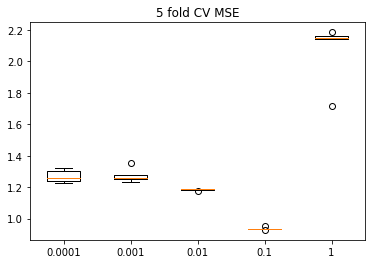

In [126]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("5 fold CV MSE")
plt.boxplot(res_dict.values(), labels=res_dict.keys());